# Stacked LSTM Classifier

In [1]:
# data analysis pkg
import pandas as pd
import matplotlib.pyplot as plt

# Word vectorization and splitting dataset
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Building sequential model
from keras.models import Model
from keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from keras.layers import Embedding, Dense, Dropout
from keras.layers import Input, concatenate

# Cofigurations
from keras.callbacks import ModelCheckpoint

# import metrics
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score


# Avoiding warnings
import warnings
import os
########### Prevent Warnings ###########
warnings.filterwarnings(action='ignore')
########### Prevent Warnings ###########

Using TensorFlow backend.


# Read data

In [2]:
df = pd.read_csv('data/cleaned/data.csv')
df.title = df.title.astype('str')
df.text = df.text.astype('str')
df.comment = df.comment.astype('str')
df.rate = df.rate.astype('category')

# Setting features and Splitting dataset 

In [3]:
# features = df.columns.tolist()[:-1]
features = ['text']
label = ['verification_status']

X_train, X_test, Y_train, Y_test = train_test_split(df[features], df[label], test_size=0.3)

X_train = [text for text in X_train.text]
Y_train = [label for label in Y_train.verification_status]

X_test = [text for text in X_test.text]
Y_test = [label for label in Y_test.verification_status]

## Set hypermeter

In [4]:
output_dir='model_output/parallel_conv/'

epochs = 4
batch_size = 128

n_dim = 64
n_unique_words = 5000
max_text_length = 500
pad_type = trunc_type = 'pre'
drop_embed = 0.2

n_conv_1 = n_conv_2 = n_conv_3 = 64
k_conv_1 = 3
k_conv_2 = 2
k_conv_3 = 4

n_dense = 256
dropout = 0.2

## Option 1 - Tokenizing and convert to sequences using keras tools

In [5]:
tok = Tokenizer(num_words=n_unique_words, lower=False)
tok.fit_on_texts(X_train)

train_sequences = tok.texts_to_sequences(X_train)
train_sequences_matrix = pad_sequences(train_sequences, maxlen=max_text_length, padding=pad_type)

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_text_length)

## Option 2 - Tokenizing and convert to sequences using sklearn tools

In [7]:
# tfidf = TfidfVectorizer(use_idf=True, max_features=n_unique_words, tokenizer=word_tokenize)
# train_sequences_matrix = tfidf.fit_transform(X_train)
# test_sequences_matrix = tfidf.transform(X_test)

In [6]:
train_sequences_matrix.shape

(125369, 500)

# Designing Model Architecture

In [7]:
def ParallelConv():
    input_layer = Input(shape=(max_text_length,), dtype='int16', name='input')
    
    embedding_layer = Embedding(n_unique_words, n_dim, input_length=max_text_length, name='embedding')(input_layer)
    drop_embedding_layer = SpatialDropout1D(drop_embed, name='drop_embed')(embedding_layer)
    
    conv_1 = Conv1D(n_conv_1, k_conv_1, activation='relu', name='conv_1')(drop_embedding_layer)
    maxp_1 = GlobalMaxPooling1D(name='maxp_1')(conv_1)
    
    conv_2 = Conv1D(n_conv_2, k_conv_2, activation='relu', name='conv_2')(drop_embedding_layer)
    maxp_2 = GlobalMaxPooling1D(name='maxp_2')(conv_2)
    
    conv_3 = Conv1D(n_conv_3, k_conv_3, activation='relu', name='conv_3')(drop_embedding_layer)
    maxp_3 = GlobalMaxPooling1D(name='maxp_3')(conv_3)
    
    concat = concatenate([maxp_1, maxp_2, maxp_3])
    
    
    dense_layer = Dense(n_dense, activation='relu', name='dense')(concat)
    drop_dense_layer = Dropout(dropout, name='drop_dense')(dense_layer)
    
    dense_layer_2 = Dense(n_dense, activation='relu', name='dense_2')(drop_dense_layer)
    drop_dense_layer_2 = Dropout(dropout, name='drop_dense_2')(dense_layer_2)
    
    predictions = Dense(1, activation='sigmoid', name='output')(drop_dense_layer_2)
    
    model = Model(input_layer, predictions)
    
    return model

In [8]:
model = ParallelConv()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 500)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 64)      320000      input[0][0]                      
__________________________________________________________________________________________________
drop_embed (SpatialDropout1D)   (None, 500, 64)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 498, 64)      12352       drop_embed[0][0]                 
____________________________________________________________________________________________

# Configure Model

In [9]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_ckpt = ModelCheckpoint(filepath=output_dir+'weights.{epoch:02d}.hdf5')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Train

In [10]:
model.fit(train_sequences_matrix, Y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          verbose=1,
          validation_data=(test_sequences_matrix, Y_test), callbacks=[model_ckpt])

Train on 125369 samples, validate on 53730 samples
Epoch 1/4
 61056/125369 [=============>................] - ETA: 1:42 - loss: 12.7955 - accuracy: 0.1655

KeyboardInterrupt: 

# Evaluate

In [11]:
model.load_weights(output_dir+'weights.02.hdf5')

In [12]:
y_hat = model.predict(test_sequences_matrix)

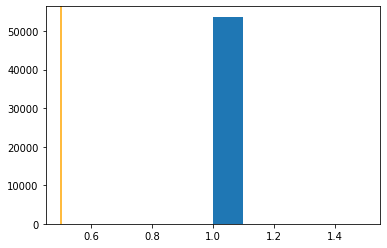

In [13]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [21]:
auc = roc_auc_score(Y_test, y_hat)*100.0
print(auc)

87.74399024307658
